This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goal is to segment cells and extract morphology features from CellProfiler.
These masks must be imported into CellProfiler to extract features.

## import libraries 

In [ ]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
from skimage import io, segmentation

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False


# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

sys.path.append(f"{root_dir}/utils/")

from parsable_args import parse_segmentation_args

## parse args and set paths

If a notebook run the hardcoded paths.
However, if this is run as a script, the paths are set by the parsed arguments.

In [ ]:
if not in_notebook:
    args_dict = parse_segmentation_args()
    patient = args_dict["patient"]
    well_fov = args_dict["well_fov"]
    clip_limit = args_dict["clip_limit"]
    twoD_method = args_dict["twoD_method"]
else:
    print("Running in a notebook")
    patient = "NF0014"
    well_fov = "C2-2"
    clip_limit = 0.01
    twoD_method = "zmax"

if twoD_method == "middle":
    input_dir = pathlib.Path(
        f"{root_dir}/data/{patient}/middle_slice_illum_correction/{well_fov}"
    ).resolve(strict=True)

elif twoD_method == "zmax":
    input_dir = pathlib.Path(
        f"{root_dir}/data/{patient}/zmax_proj_illum_correction/{well_fov}"
    ).resolve(strict=True)
else:
    raise ValueError(f"Unknown twoD_method: {twoD_method}")

mask_path = input_dir

Running in a notebook


## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

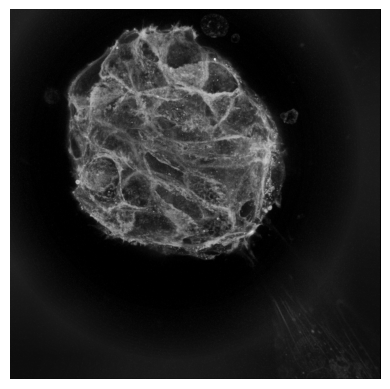

In [4]:
# get the nuclei image
for f in files:
    if "555" in f:
        cell = io.imread(f)
    elif "nuclei_mask" in f:
        nuclei_mask = io.imread(f)
cell = np.array(cell)
cell = skimage.exposure.equalize_adapthist(cell, clip_limit=clip_limit)
nuclei_mask = np.array(nuclei_mask)
if in_notebook:
    plt.imshow(cell, cmap="gray")
    plt.axis("off")
    plt.show()

## Watershed the cells from the nuclei

In [5]:
labels = np.zeros_like(cell, dtype=np.int32)
# get the seeds from the nuclei mask
seeds = skimage.measure.label(nuclei_mask, connectivity=2)
labels = segmentation.watershed(cell, markers=seeds)
# make sure the background is labeled as 0
labels[labels == -1] = 0
# set the largest label to 0 (background)
largest_label = np.bincount(labels.ravel()).argmax()
labels[labels == largest_label] = 0
# # save the labels
labels_path = input_dir / f"{well_fov}_cell_masks.tiff"
tifffile.imwrite(labels_path, labels.astype(np.uint16))

<Figure size 1000x500 with 0 Axes>

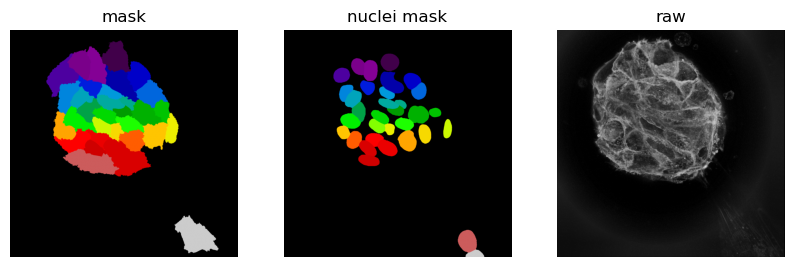

In [6]:
if in_notebook:
    plot = plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("mask")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(nuclei_mask, cmap="nipy_spectral")
    plt.title("nuclei mask")
    plt.axis("off")

    plt.subplot(133)
    plt.imshow(cell, cmap="gray")
    plt.title("raw")
    plt.axis("off")